Importing libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import seaborn as sb
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df_train = pd.read_csv("train.tsv", delimiter='\t')
df_test = pd.read_csv("test.tsv", delimiter='\t')

In [4]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


train_id and test_id don't have anything to do with predicting the price, so we drop them.

In [5]:
df_train=df_train.drop(['train_id'],1)
df_test=df_test.drop(['test_id'],1)

In [6]:
df_train.shape

(1482535, 7)

Chaning the categorical variables to numerics and add them to the DF

In [7]:
trainData=df_train.copy()
le = preprocessing.LabelEncoder()
trainData['category_id']= le.fit_transform(df_train.category_name.astype(str))
trainData['brand_id']= le.fit_transform(df_train.brand_name.astype(str))

In [8]:
trainData.columns

Index(['name', 'item_condition_id', 'category_name', 'brand_name', 'price',
       'shipping', 'item_description', 'category_id', 'brand_id'],
      dtype='object')

In [9]:
trainData.dtypes

name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
category_id            int64
brand_id               int64
dtype: object

In [10]:
trainData.isnull().sum()

name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
category_id               0
brand_id                  0
dtype: int64

many NAN values in category_name and brand name
# need to solve this 

In [11]:
trainData.brand_name.nunique()

4809

What brands are popular

In [12]:
BrandValueCount=df_train['brand_name'].value_counts()
print(BrandValueCount[BrandValueCount > 10000])

PINK                 54088
Nike                 54043
Victoria's Secret    48036
LuLaRoe              31024
Apple                17322
FOREVER 21           15186
Nintendo             15007
Lululemon            14558
Michael Kors         13928
American Eagle       13254
Rae Dunn             12305
Sephora              12172
Coach                10463
Disney               10360
Bath & Body Works    10354
Adidas               10202
Name: brand_name, dtype: int64


In [13]:
trainData.category_name.nunique()

1287

In [14]:
trainData['shipping'].value_counts()

0    819435
1    663100
Name: shipping, dtype: int64

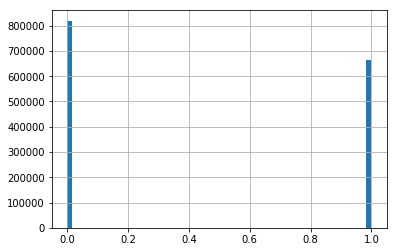

In [15]:
trainData['shipping'].hist(bins='auto')

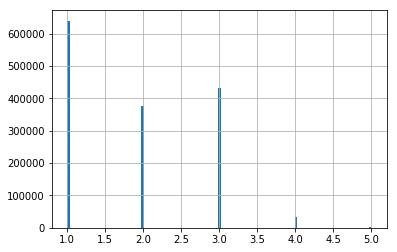

In [16]:
trainData['item_condition_id'].hist(bins='auto')

condition 4 and 5 happen rarely

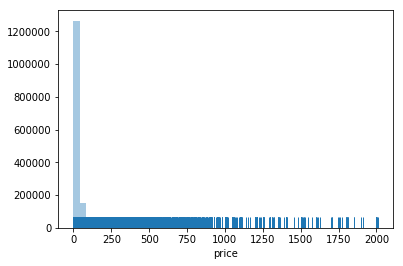

In [17]:
#Three ways to plot the histogram
#sb.distplot(trainData['price']);
sb.distplot(trainData['price'], kde=False, rug=True);

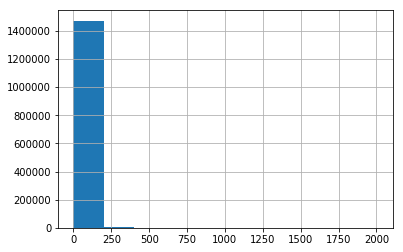

In [18]:
trainData['price'].hist()

The price column is very skewed to the left. log can reduce that skewness and (+1) is to avoid log(0)

In [19]:
trainData['logPrice']=np.log(trainData['price']+1)

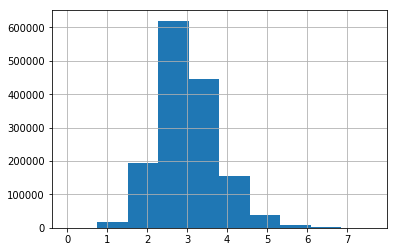

In [20]:
trainData['logPrice'].hist()

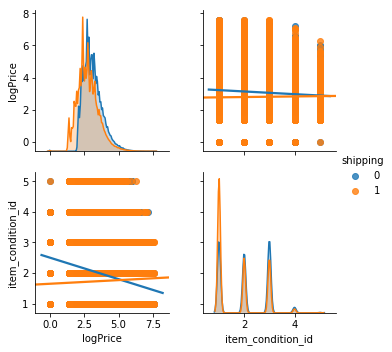

In [21]:
sb.pairplot(trainData, vars=["logPrice", "item_condition_id"], kind = 'reg', hue='shipping', diag_kind = 'kde')

Lots of shipping payment in item_condition 1, when item condition changes to 3, it looks sender shippment is more popular than buyer shippment.
Also as item_condition_id gets closer to 1, more items will be charged for shippemt. 
Items with 1 shippemt are slightly cheaper than shippment 1. 

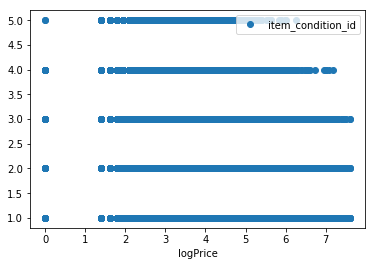

In [22]:
trainData.plot(x='logPrice', y='item_condition_id', style='o' )

In [23]:
#takes so long to plot
#sb.kdeplot(trainData['logPrice'], trainData['item_condition_id'])

In [24]:
#get some queries to have a good understanding of the data
df_train.query('price > 200 & brand_name == "Apple"').count()

name                 1881
item_condition_id    1881
category_name        1880
brand_name           1881
price                1881
shipping             1881
item_description     1881
dtype: int64

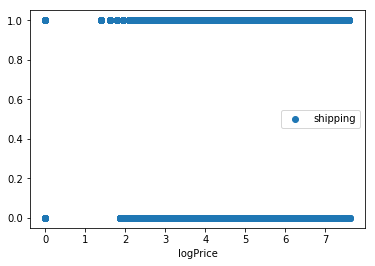

In [25]:
trainData.plot(x='logPrice', y='shipping',style='o' )

In [26]:
trainData.corr()

,item_condition_id,price,shipping,category_id,brand_id,logPrice
item_condition_id,1.000000,-0.000807,-0.191154,0.176928,-0.141512,-0.002073
price,-0.000807,1.000000,-0.097211,0.048377,-0.113608,0.738494
shipping,-0.191154,-0.097211,1.000000,-0.143457,0.101608,-0.229738
category_id,0.176928,0.048377,-0.143457,1.000000,-0.123406,0.119180
brand_id,-0.141512,-0.113608,0.101608,-0.123406,1.000000,-0.141033
logPrice,-0.002073,0.738494,-0.229738,0.119180,-0.141033,1.000000


^^^^^^
Do not do this. df.corr() calculates Pearson correlation by default. This means when using LabelEncoder on the categorical columns, a higher importance is placed on categories encoded with a higher integer, which makes it totally useless for correlation analysis

For finding the correlation between two categorical variables, we should use Cremer. 
In statistics, Cramér's V is a measure of association between two nominal variables, giving a value between 0 and +1 (inclusive). It is based on Pearson's chi-squared statistic. 

In [27]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = numerator/denominator
    return eta

In [28]:
from collections import Counter
import scipy.stats as ss


In [29]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

#two categorical cariables
def theils_u(x, y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x

In [30]:
correlation_ratio(trainData['category_name'],trainData['price'])

0.16766094100407536

In [31]:
correlation_ratio(trainData['brand_name'],trainData['price'])

0.17902114755705992

In [32]:
theils_u(trainData['brand_name'], trainData['category_name'])

0.4320126044553501

In [33]:
theils_u(trainData['category_name'],trainData['name'])

0.9762910621801335

This part is to find uncertainty coeficient for categorical variable. 

              category_name brand_name
brand_name         0.432013          1
category_name             1   0.298633


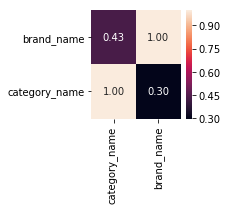

In [53]:
theilu = pd.DataFrame(index=['brand_name', 'category_name'],columns=trainData.columns[2:4])
columns = trainData.columns[2:4]
for j in range(0,len(columns)):
    for i in range(0,len(columns)):
        u = theils_u(trainData[columns[i]],trainData[columns[j]])
        theilu.loc[columns[i],columns[j]] = u
print(theilu)
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(2,2))
sb.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

0.16766094100407536
0.17902114755705992
       category_name  brand_name
price       0.167661    0.179021


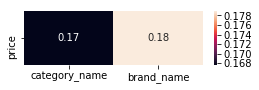

In [85]:
CorrRatio = pd.DataFrame(index=['price'],columns=trainData.columns[4:4])
columns = trainData.columns[2:4]
for j in range(0,len(columns)):
    #for i in range(0,len(columns)):
        u = correlation_ratio(trainData[columns[j]], trainData['price'])
        u = u*1
        print(u)
        CorrRatio.loc[:,columns[j]] = u
CorrRatio.fillna(value=np.nan,inplace=True)
print(CorrRatio)
plt.figure(figsize=(4,1))
sb.heatmap(CorrRatio,annot=True,fmt='.2f')
plt.show()

0.16766094100407536
0.2040193956468266
0.17902114755705992
0.10424817645469078
                   category_name  brand_name
price                   0.167661    0.179021
item_condition_id       0.204019    0.104248


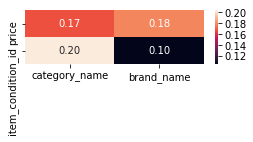

In [109]:
CorrRatio = pd.DataFrame(index=['price'])
columns = trainData.columns[2:4]#columns labels
rows = ['price','item_condition_id'] # rows
          
for j in range(0,len(columns)):
    for i in range(0,len(rows)):
        u = correlation_ratio(trainData[columns[j]], trainData[rows[i]])
        u = u*1
        print(u)
        CorrRatio.loc[rows[i],columns[j]] = u
CorrRatio.fillna(value=np.nan,inplace=True)
print(CorrRatio)
plt.figure(figsize=(4,1))
sb.heatmap(CorrRatio,annot=True,fmt='.2f')
plt.show()

In [111]:
correlation_ratio(trainData['brand_name'], trainData['item_condition_id'])

0.10424817645469078

In [51]:
trainData.columns[3]

'brand_name'

In [86]:
trainData.columns[4:4]

Index([], dtype='object')

In [97]:
trainData.columns[2:4]

Index(['category_name', 'brand_name'], dtype='object')